load the necessary modules

In [282]:
%load_ext autoreload
%autoreload 2
import iarray as ia
import run2019

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
ia.plt.rcParams['font.size'] = 15

# run2019 analysis

## expected rate

### neutrino flux

The neutrino reactor flux is
$$
\frac{d\Phi}{d E_{\nu}} = \frac{ d^3 N_{\nu} }{ d E_{\nu} d\sigma dt }
$$
with units counts/MeV/cm$^2$/s

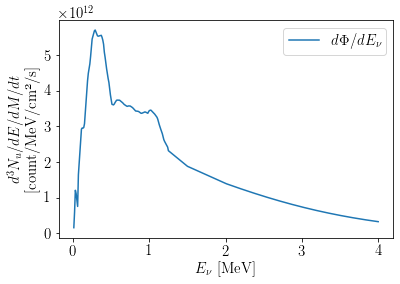

In [143]:
flux_nu = ia.genfromcsv(
    "data/reactorFlux.csv", 
    x = dict( name=r"$E_\nu$", unit=ia.MeV, dim="Enu" ), 
    y = dict( name=r"$d\Phi/d E_\nu$", unit=ia.ureg("counts/MeV/cm^2/s") ) 
)
flux_nu.xplot(ylabel="$d^3N_\nu/dE/dM/dt$")

### cross section

The Standard Model CEvNS cross section is
$$
\frac{ d\sigma }{d E_{\rm R}} = \frac{G_F^2}{4\pi} Q_W^2 \left(
    1 - \frac{E_R}{E_\nu} + (E_R - M)\frac{E_R}{2E_\nu^2}
\right) M F^2
$$
where
$$
G_F = 1.1663787 \cdot 10^{-5} \text{GeV}^{-2}\quad \text{Fermi constant}
\\
Q_W = N = 14 \quad \text{weak nuclear charge}
\\
M = 28.085 \text{u} = 28.085 \cdot 9.314 \cdot 10^5 \text{keV}\quad \text{Silicon atomic mass}
\\
F = 1 \quad \text{nuclear form factor}
$$

In [214]:
E_R = ia.Coord(r"$E_{\rm R}$", "Er", ia.arange(0,2,.01)*ia.keV )
print( E_R )
print( flux_nu.xcoords[0] )

<xarray.DataArray '$E_{\\rm R}$' (Er: 200)>
<Quantity([0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.

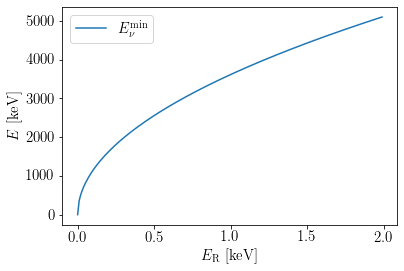

In [145]:
def E_nu_min(ER):
    M = run2019.M_Si_amu * ia.amu
    return ia.Array(r"$E_\nu^{\rm min}$", data = ( ER + ia.sqrt( ER**2 + 2*M*ER) )/2 )

E_nu_min( E_R ).xplot( ylabel=r"$E$" )

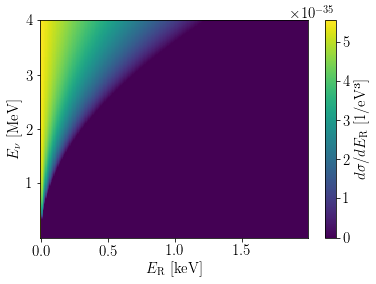

In [189]:
def dsigma__dE_R( ER, Enu ):
    M = run2019.M_Si_amu * ia.amu
    Enu_min = ia.Array(r"$E_\nu^{\rm min}$", data = ( ER + ia.sqrt( ER**2 + 2*M*ER) )/2 )
    F = 1
    QW = 14
    GF = 1.1663787e-5 / ia.GeV**2.
    data = GF**2./(4*ia.pi) * QW**2. * ( 1 - ER/Enu + ER*(ER - M)/2/Enu**2. ) * M * F**2.
    return ia.Array( r"$d\sigma/dE_{\rm R}$", data = data ).where( Enu > Enu_min, 0 )

dsigma__dE_R(E_R, flux_nu.get_coords(0)).xplot()

### recoil rate

The rate of recoil events is obtained by convoluting the neutrino flux with the cross section and multiplying by the number of Silicon nuclei per kg
$$
\frac{dR}{d E_R} = N_T \int_{E_\nu^\text{min}}^\infty dE_\nu \frac{d\Phi}{dE_\nu} \frac{d\sigma}{dE_R}
$$
which can be expressed as
$$
\frac{d^3N}{d E_R dM dt} = \frac{dN_T}{dM} \int_{E_\nu^\text{min}}^\infty dE_\nu \frac{d^3 N}{dE_\nu d\sigma dt} \frac{d\sigma}{dE_R}
$$
where
$$
E_\nu^\text{min} = \frac{1}{2} \left( E_R + \sqrt{ E_R^2 + 2ME_R } \right)
\\
\frac{dN_T}{dM} = \frac{6.022 \cdot 10^{23} }{28.084 \cdot 10^{-3} \text{kg}}
$$

However, the differential cross section is at natural units, while the neutrino flux is in SI. 
In order to make them compatible, the quantities are converted to barn.
$$
\text{SI:}\quad \text{cm}^2 = 10^{27}\text{mb}
\\
\text{natural:}\quad \text{GeV}^{-2} = \frac{1}{2.56819} \text{mb}
$$
dividing both gives
$$
\text{cm}^2\text{GeV}^2 = 2.56819 \cdot 10^{27}
$$

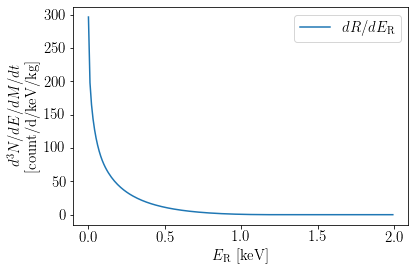

In [165]:
def dR__dE_R( E_R, flux_nu ):
    to_barn = ia.ureg( "cm^2.*GeV^2." )/2.568e27
    N_T = (6.022e23/(28.084 * ia.ureg.g) ).to('1/kg')
    return ia.Array(
        r"$dR/dE_{\rm R}$",
        data = N_T * flux_nu * dsigma__dE_R( E_R, flux_nu.xcoords[0] ) * to_barn
    ).integrate( flux_nu.xcoords[0].name )

dR__dE_R( E_R, flux_nu ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")

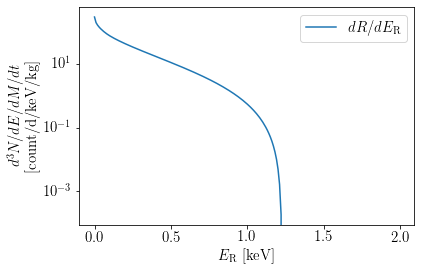

In [168]:
dR__dE_R( E_R, flux_nu ).xplot(ylabel=r"$d^3N/dE/dM/dt$", yscale="log", unit="count/keV/kg/day")

### quenching factor

The quenching factor is defined as the fraction of the Silicon recoil energy which is converted to electron ionization energy,
$$
E_I = Q E_R
$$

To convertion from recoil energy to ionization energy,
$$
E_R \rightarrow E_I = Q E_R
$$
therefore
$$
f(E_R) \rightarrow f(Q E_R)
$$
furtheremore,
$$
\frac{df(E_R)}{dE_R} \rightarrow \frac{df(Q E_R)}{d(Q E_R)}
= \frac{dE_R}{d(Q E_R)} \frac{df(Q E_R)}{dE_R} 
$$

In the case the quenching factor is defined as a function of the ionization energy $Q = Q(E_I)$,
$$
\frac{dE_R}{dE_I} = \frac{d}{dE_I}\left(\frac{E_I}{Q(E_I)}\right)
= \left( \frac{1}{Q(E_I)} - \frac{E_I}{Q(E_I)^2} \frac{dQ(E_I)}{dE_I} \right)
$$

In the case the quenching factor is defined as a function of the recoil energy $Q = Q(E_R)$,
$$
\frac{dE_R}{dE_I} = \left( \frac{d}{dE_R}(Q(E_R) E_R) \right)^{-1} = \left( Q(E_R) + E_R \frac{dQ(E_R)}{dE_R} \right)^{-1}
$$
which converts into
$$
\frac{dE_R}{dE_I} = \left( Q(E_R) + E_R \frac{dQ(E_R)}{dE_R} \right)^{-1}
$$


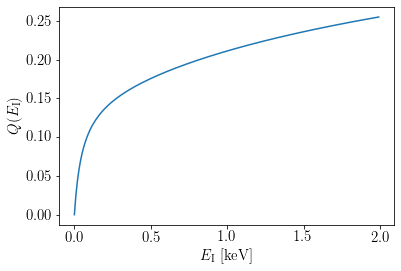

In [170]:
E_I = ia.Coord(r"$E_{\rm I}$", "Ei", ia.arange(0,2,.01)*ia.keV )

def Q(E_I):
    p0 = 56 * ia.keV**3.
    p1 = 1096 * ia.keV**2
    p2 = 382 * ia.keV
    p3 = 168 * ia.keV**2
    p4 = 155 * ia.keV
    N = p3*E_I + p4*E_I**2 + E_I**3
    D = p0 + p1*E_I + p2*E_I**2
    return ia.Array( r"$Q(E_{\rm I})$", data = N/D )

Q(E_I).xplot()

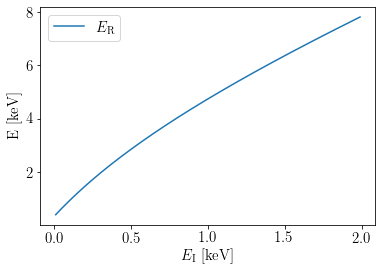

In [172]:
ia.Array( r"$E_{\rm R}$", data = E_I/Q(E_I) ).xplot(ylabel="$E$")

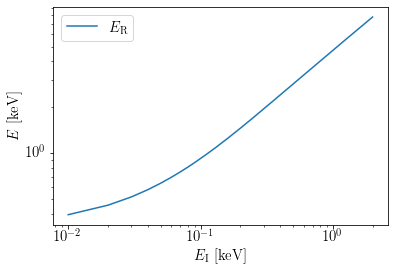

In [188]:
ia.Array( r"$E_{\rm R}$", data = E_I/Q(E_I) ).xplot(ylabel="$E$", xscale="log", yscale="log")

### ionization rate

the ionization energy is obtained by computing the conversion factor between the Silicon recoil energy and the electron ionization energy
$$
\frac{dE_R}{dE_I}(E_I) = \frac{1}{Q(E_I)^2}\left( Q(E_I) - E_I \frac{dQ}{dE_I}(E_I) \right)
$$

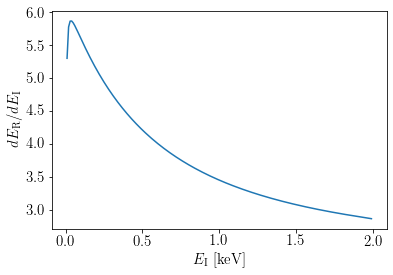

In [184]:
def dE_R__dE_I(E_I):
    return ia.Array(
        r"$dE_{\rm R}/dE_{\rm I}$",
        data = 1./Q(E_I) - E_I/Q(E_I)**2 * Q(E_I).xdiff()
    )

dE_R__dE_I(E_I).xplot()

the ionization rate is then
$$
\frac{dR}{dE_I}(E_I) = \frac{dE_R}{dE_I}(E_I) \frac{dR}{dE_R}(E_I)
$$

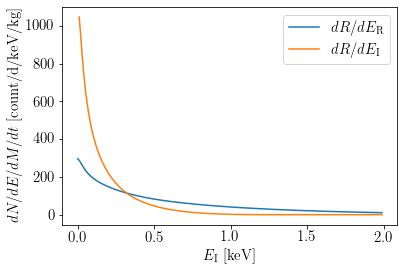

In [187]:
def dR__dE_I(E_I, flux_nu):
    return ia.Array(
        r"$dR/dE_{\rm I}$",
        data = dR__dE_R(E_I, flux_nu) * dE_R__dE_I(E_I)
    )

dR__dE_R( Q(E_I)*E_I, flux_nu ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")
dR__dE_I( E_I, flux_nu ).xplot(ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day")

The comparison between the Silicon recoil and the electron ionization rates show that the rate is higher for the ionization

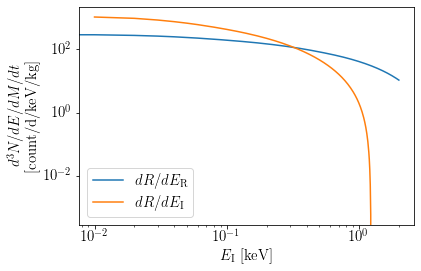

In [191]:
dR__dE_R( Q(E_I)*E_I, flux_nu ).xplot( yscale="log", xscale="log", ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day" )
dR__dE_I( E_I, flux_nu ).xplot( yscale="log", xscale="log", ylabel=r"$d^3N/dE/dM/dt$", unit="count/keV/kg/day" )

## runID selection

a function to load the data from the catalog files

In [321]:
import iarray as ia
dataset = ia.genfromroot( 
    run2019.data_files, 
    "hitSumm", 
    branches = {
        r"$\sigma_{\rm raw}$": "rawNoise", 
        r"$\lambda_{\rm raw}$": "rawDC", 
        r"$\sigma_{\rm scn}$": "scnNoise", 
        r"$\lambda_{\rm scn}$": "scnDC", 
        r"runID": "runID", 
        r"hdu": "ohdu"
    }, 
    cut = str( run2019.on_excl*run2019.excluded_ohdu )
)
on_dataset_grouped = ia.groupby( dataset, ["hdu", "runID"], func=lambda x: x[0] )
print( on_dataset_grouped )

dims [8, 735]
[[   2 6032]
 [   3 6032]
 [   4 6032]
 ...
 [   9 7521]
 [  13 7521]
 [  14 7521]]
combinations (5880, 2)
$\sigma_{\rm raw}$
$\lambda_{\rm raw}$
$\sigma_{\rm scn}$
$\lambda_{\rm scn}$
<xarray.Dataset>
Dimensions:              (hdu: 8, runID: 735)
Coordinates:
  * hdu                  (hdu) int32 2 3 4 5 8 9 13 14
  * runID                (runID) int32 6032 6033 6034 6035 ... 7519 7520 7521
Data variables:
    $\sigma_{\rm raw}$   (runID, hdu) float32 13.31 13.99 13.2 ... 13.58 12.69
    $\lambda_{\rm raw}$  (runID, hdu) float32 0.2667 0.2844 ... 0.2911 0.2615
    $\sigma_{\rm scn}$   (runID, hdu) float32 1.986 1.685 1.861 ... 1.572 1.665
    $\lambda_{\rm scn}$  (runID, hdu) float32 0.04396 0.04026 ... 0.02977


In [322]:
import iarray as ia
dataset = ia.genfromroot( 
    run2019.data_files, 
    "hitSumm", 
    branches = {
        r"$\sigma_{\rm raw}$": "rawNoise", 
        r"$\lambda_{\rm raw}$": "rawDC", 
        r"$\sigma_{\rm scn}$": "scnNoise", 
        r"$\lambda_{\rm scn}$": "scnDC", 
        r"runID": "runID", 
        r"hdu": "ohdu"
    }, 
    cut = str( run2019.off_excl*run2019.excluded_ohdu )
)
off_dataset_grouped = ia.groupby( dataset, ["hdu", "runID"], func=lambda x: x[0] )
print( off_dataset_grouped )

dims [8, 652]
[[   2 6227]
 [   3 6227]
 [   4 6227]
 ...
 [   9 6974]
 [  13 6974]
 [  14 6974]]
combinations (5216, 2)
$\sigma_{\rm raw}$
$\lambda_{\rm raw}$
$\sigma_{\rm scn}$
$\lambda_{\rm scn}$
<xarray.Dataset>
Dimensions:              (hdu: 8, runID: 652)
Coordinates:
  * hdu                  (hdu) int32 2 3 4 5 8 9 13 14
  * runID                (runID) int32 6227 6228 6229 6230 ... 6972 6973 6974
Data variables:
    $\sigma_{\rm raw}$   (runID, hdu) float32 13.71 14.36 13.51 ... 13.68 12.99
    $\lambda_{\rm raw}$  (runID, hdu) float32 0.2586 0.2888 ... 0.288 0.2535
    $\sigma_{\rm scn}$   (runID, hdu) float32 1.997 1.694 1.873 ... 1.567 1.7
    $\lambda_{\rm scn}$  (runID, hdu) float32 0.04168 0.03634 ... 0.02901


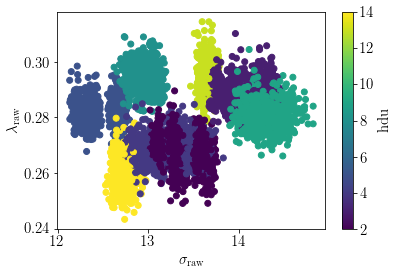

In [319]:
on_dataset_grouped.plot.scatter(y=r"$\lambda_{\rm raw}$", x=r"$\sigma_{\rm raw}$", hue="hdu");

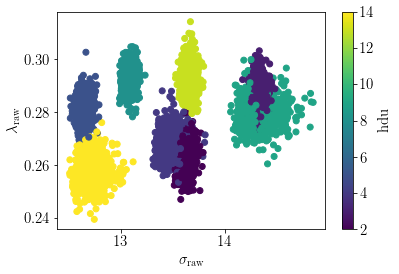

In [327]:
off_dataset_grouped.where(off_dataset_grouped[r"$\sigma_{\rm raw}$"] > 5).plot.scatter(y=r"$\lambda_{\rm raw}$", x=r"$\sigma_{\rm raw}$", hue="hdu");

<xarray.Dataset>
Dimensions:              (hdu: 8)
Coordinates:
  * hdu                  (hdu) int32 2 3 4 5 8 9 13 14
Data variables:
    $\sigma_{\rm raw}$   (hdu) float32 13.43 14.09 13.23 ... 14.28 13.65 12.74
    $\lambda_{\rm raw}$  (hdu) float32 0.267 0.2892 0.2689 ... 0.2947 0.2595
    $\sigma_{\rm scn}$   (hdu) float32 1.989 1.691 1.849 ... 1.758 1.57 1.664
    $\lambda_{\rm scn}$  (hdu) float32 0.04488 0.03717 ... 0.03464 0.02964


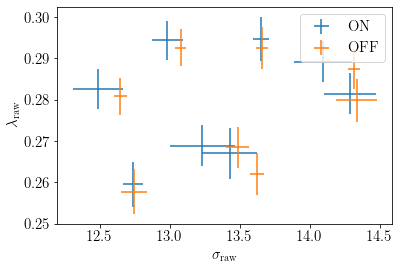

In [373]:
%autoreload 2
import iarray as ia
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 15})
print( on_dataset_grouped.mean("runID") )
on_dataset_grouped.where(on_dataset_grouped[r"$\sigma_{\rm raw}$"] > 5).stats("runID").errorbar( 
    x=r"$\sigma_{\rm raw}$", 
    y=r"$\lambda_{\rm raw}$", 
    fmt = " ",
    label = "ON"
)
off_dataset_grouped.where(off_dataset_grouped[r"$\sigma_{\rm raw}$"] > 5).stats("runID").errorbar( 
    x=r"$\sigma_{\rm raw}$", 
    y=r"$\lambda_{\rm raw}$", 
    fmt = " ",
    label = "OFF"
)
plt.legend();

## acceptance

The acceptance is computed  by simulating events with given ionization energies and confirming the rate of reconstruction
$$
\frac{dN}{dE_I} = {\cal A}(E_{\rm I})\frac{dN_S}{dE_I},
$$

### simulation spectrum

In [553]:
import iarray as ia
def dNsim__dE_I( E_I, cut ):
    data = ia.genfromroot( 
        run2019.sim_files, 
        treename="hitSumm",  
        branches = {"E": ("oEnergy", "eV"), "hdu": "hdu"},
        cut = str(cut*run2019.excluded_hdu),
    )
    return data.xhistogram("hdu", centers=E_I, per_bin=True)

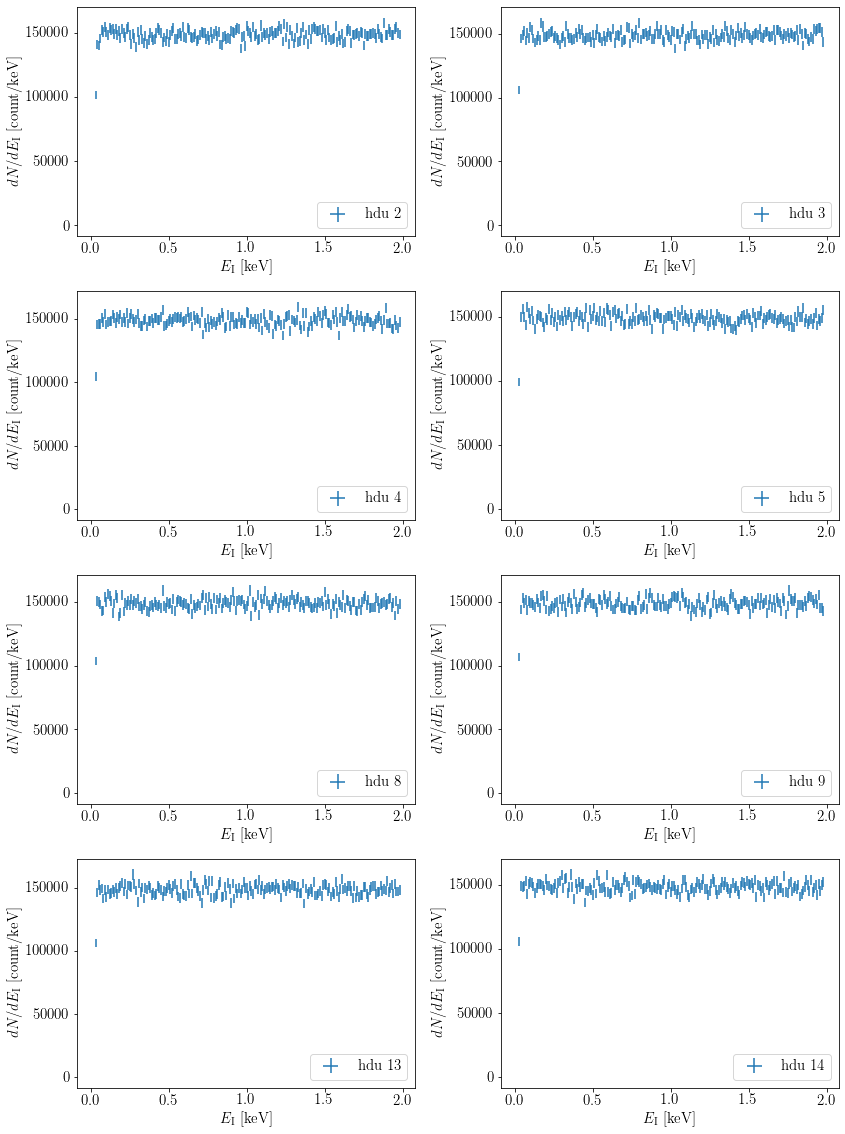

In [554]:
( 
    dNsim__dE_I( E_I, run2019.on_excl )
).errorbar(x=r"$E_{\rm I}$", y=r"$dN/dE_{\rm I}$", z="hdu", fmt=" ")

### matched spectrum

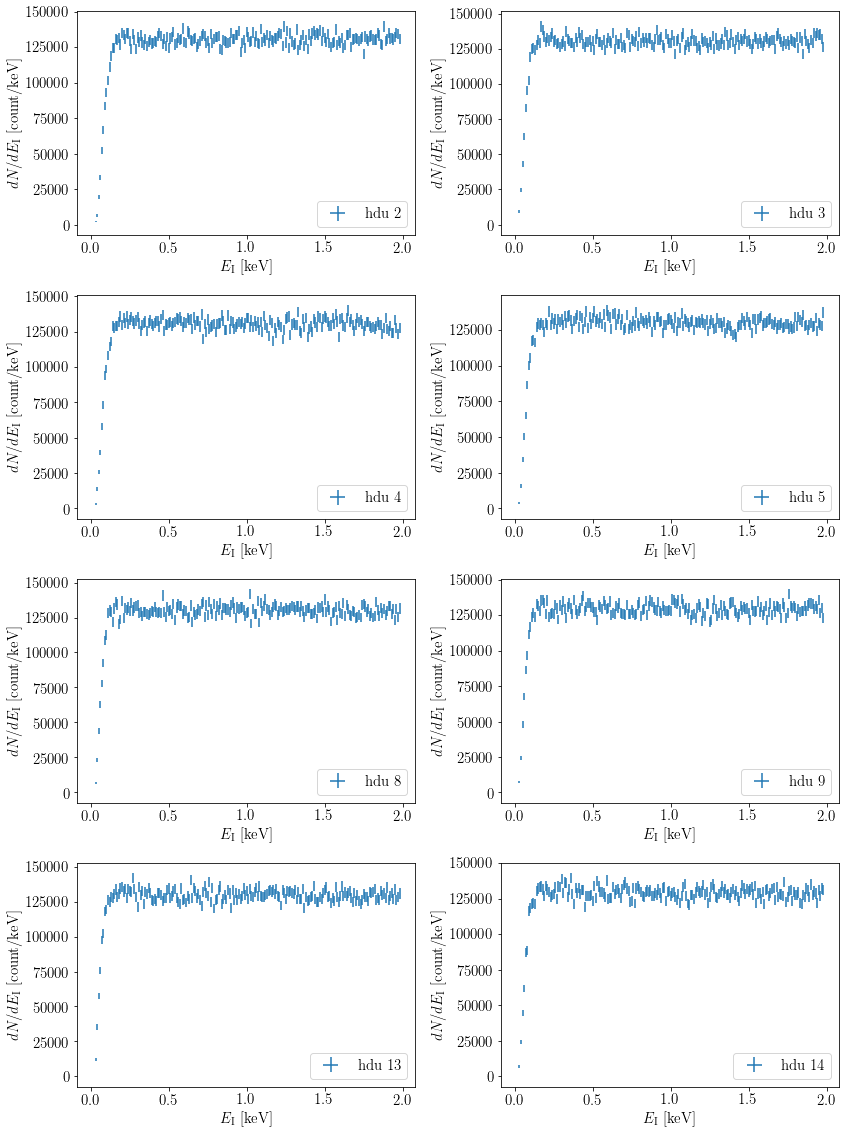

In [558]:
def dNmatch__dE_I( E_I, cut, distSim=1.5 ):
    data = ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {"E": ("oEnergy", "eV"), "hdu": "ohdu"},
        cut = str(cut*run2019.excluded_ohdu*f'distSim<={distSim}'),
    )
    return data.xhistogram("hdu", centers=E_I, per_bin=True)

dNmatch__dE_I( E_I, run2019.on_excl ).errorbar(x=r"$E_{\rm I}$", y=r"$dN/dE_{\rm I}$", z="hdu", fmt=" ")

### acceptance per hdu

<xarray.Dataset>
Dimensions:             (Ei: 198, hdu: 8)
Coordinates:
  * hdu                 (hdu) int32 2 3 4 5 8 9 13 14
    $E_{\rm I}$         (Ei) float64 [keV] 0.01 0.02 0.03 ... 1.96 1.97 1.98
Dimensions without coordinates: Ei
Data variables:
    $\mathcal{A}(E_I)$  (hdu, Ei) object [] 0.0 0.0 ... 0.861+/-0.032


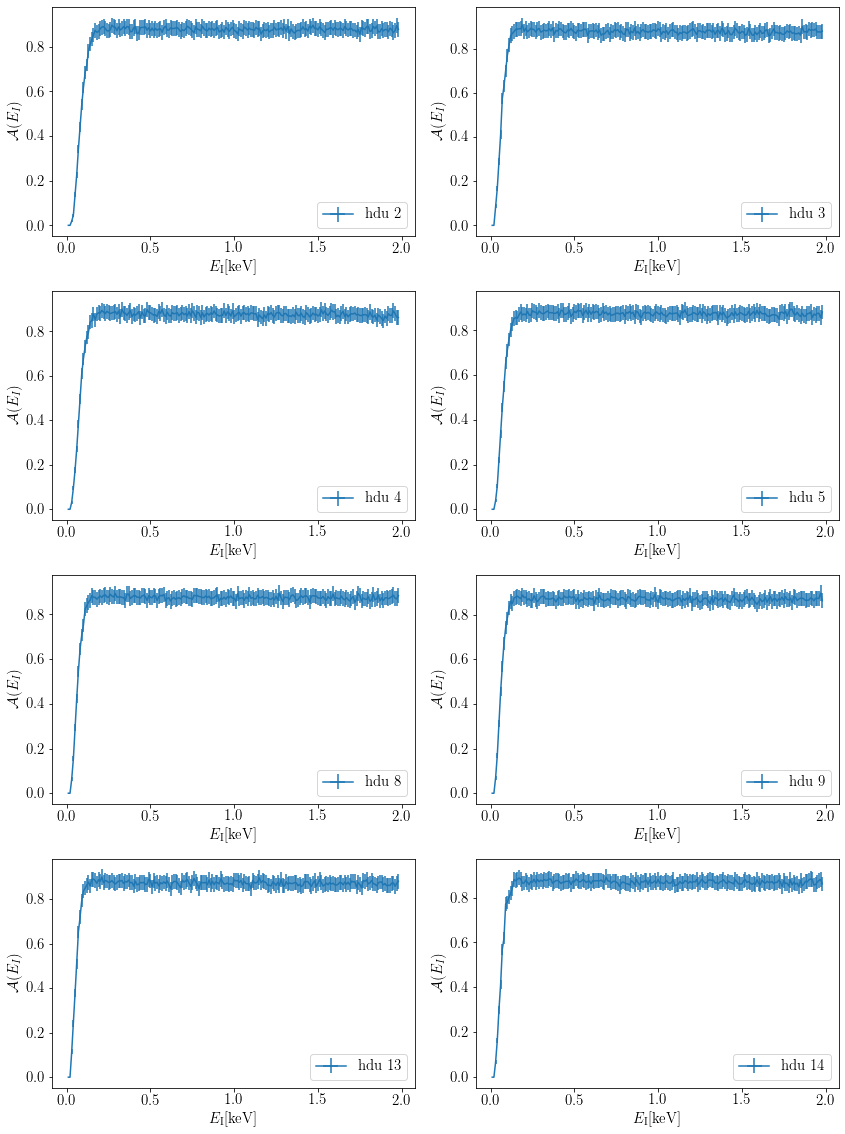

In [568]:
def Acceptance(E_I, cut):
    sim = dNsim__dE_I(E_I, cut)[r"$dN/dE_{\rm I}$"]
    match = dNmatch__dE_I(E_I, cut)[r"$dN/dE_{\rm I}$"]
    sim_where = sim.where(sim.pint.magnitude>0, 1*sim.pint.units)
    match_where = match.where(sim.pint.magnitude>0, 0*sim.pint.units)
    return ia.xr.Dataset(
        data_vars = {r"$\mathcal{A}(E_I)$": match_where/sim_where }
    )

ia.iprint( Acceptance(E_I, run2019.on_excl) ).errorbar(x=r"$E_{\rm I}$", y=r"$\mathcal{A}(E_I)$", z="hdu", cols_wrap=2);

### acceptance fit

fitting function
$$
p_{2} \left(
    \frac{1}{2}\tanh\left( 
        \frac{x-p_1}{p_0}
    \right) + \frac{1}{2}
\right)^{10}
=
p_{2} \text{step}( x-p_1, p_0 )^{10}
$$

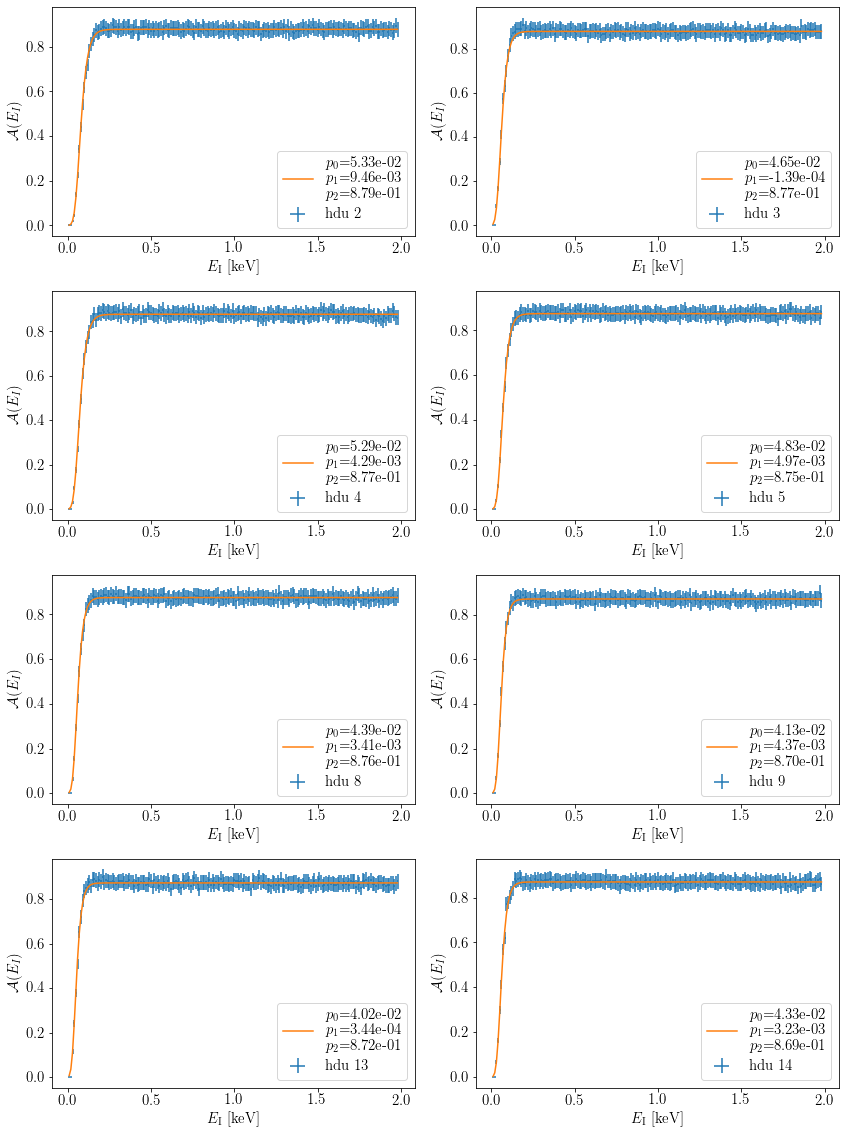

In [575]:
step = lambda x, p: ia.np.tanh(x/p)/2 + 1/2
tanhFit = lambda x, *p, step=step: p[2]*step(x - p[1], p[0])**10
tanhFit_str = "p[2]*step(x - p[1], p[0] )**10"
Acceptance(E_I, run2019.on_excl)[r"$\mathcal{A}(E_I)$"].curve_fit(
    x = r"$E_{\rm I}$", 
    z = "hdu", 
    func = tanhFit,
    p0 = [10,10,10]
).errorbar(x=r"$E_{\rm I}$", z="hdu", cols_wrap=2);

In [583]:
def A_fit( E_I, period, func, p0 ):
    a = Acceptance(E_I, period)[r"$\mathcal{A}(E_I)$"].curve_fit(
        x = r"$E_{\rm I}$", 
        z = "hdu", 
        func = func,
        p0 = p0
    )
    fit = a.attrs["fit"]
    x = E_I.pint.magnitude
    b = [ fit.attrs["func"]( x, *fit.sel(hdu=sel).data ) for sel in fit["hdu"] ]
    return ia.xr.DataArray(
        b, 
        dims=["hdu", *E_I.dims],
        coords = {
            E_I.name: E_I,
            "hdu": a["hdu"]
        }
    )#.set_coords(E_I=E_I, hdu=a["hdu"])

ia.iprint(A_fit(E_I, run2019.on_excl, tanhFit, [10,10,10]));

<xarray.DataArray (hdu: 8, Ei: 200)>
array([[1.24457965e-04, 9.49657760e-04, 5.10688865e-03, ...,
        8.78673118e-01, 8.78673118e-01, 8.78673118e-01],
       [8.82946951e-04, 5.98468292e-03, 2.61835172e-02, ...,
        8.77483315e-01, 8.77483315e-01, 8.77483315e-01],
       [3.68314417e-04, 2.37984666e-03, 1.08200756e-02, ...,
        8.77447514e-01, 8.77447514e-01, 8.77447514e-01],
       ...,
       [2.79043969e-04, 3.03082858e-03, 1.86040163e-02, ...,
        8.69995048e-01, 8.69995048e-01, 8.69995048e-01],
       [7.81818735e-04, 7.05781652e-03, 3.57307496e-02, ...,
        8.72261172e-01, 8.72261172e-01, 8.72261172e-01],
       [3.91987348e-04, 3.58626561e-03, 1.95960609e-02, ...,
        8.69405892e-01, 8.69405892e-01, 8.69405892e-01]])
Coordinates:
    $E_{\rm I}$  (Ei) float64 [keV] 0.0 0.01 0.02 0.03 ... 1.96 1.97 1.98 1.99
  * hdu          (hdu) int32 2 3 4 5 8 9 13 14
Dimensions without coordinates: Ei


## acceptance rate

da_errorbar


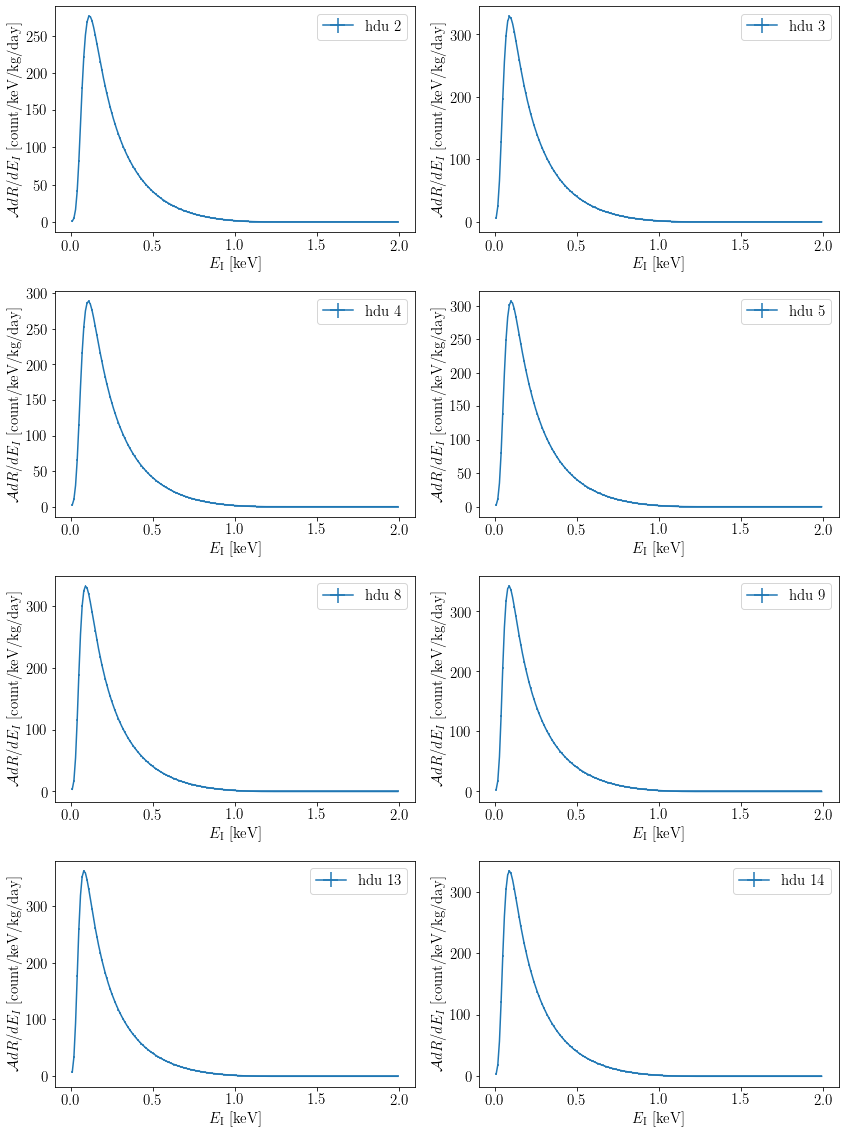

In [597]:
def AdR__dE_I(E_I, flux_nu, period, func=tanhFit, p0=[10,10,10]):
    a = A_fit( E_I, period, func, p0 )
    b = dR__dE_I(E_I, flux_nu)
    return ia.Array(
        name = r"$\mathcal{A}dR/dE_I$",
        data = a * b,
        coords = [a["hdu"], E_I]
    )

( AdR__dE_I(E_I, flux_nu, run2019.on_excl) ).errorbar(
    x=r"$E_{\rm I}$", 
    yunits="count/keV/kg/day",
    z="hdu", 
    fmt="", 
    cols_wrap=2
);

## energy dispersion

Multiple effects contribute for dispcrepancy between the measured energy and the ionization energy.
The main contribution comes from the reconstruction algorithm.
In order to account for it, the reconstructed energy is compared to the simulated energy in the matching catalogs.
Then the rate is corrected by convoluting the ionization energy with the dispersion kernel as
$$
\frac{d^3N_{\rm M} }{dEdMdt}(E_M) = 
\int_{E_{\rm min}}^{\infty} dE_I 
    \mathcal{A}(E_I) \frac{d^3N_{\rm I} }{dEdMdt}(E_I)
    G\left( E_M - E_I - \mu(E_M), \sigma(E_M) \right)
$$

dict_keys([2, 3, 4, 5, 8, 9, 13, 14])


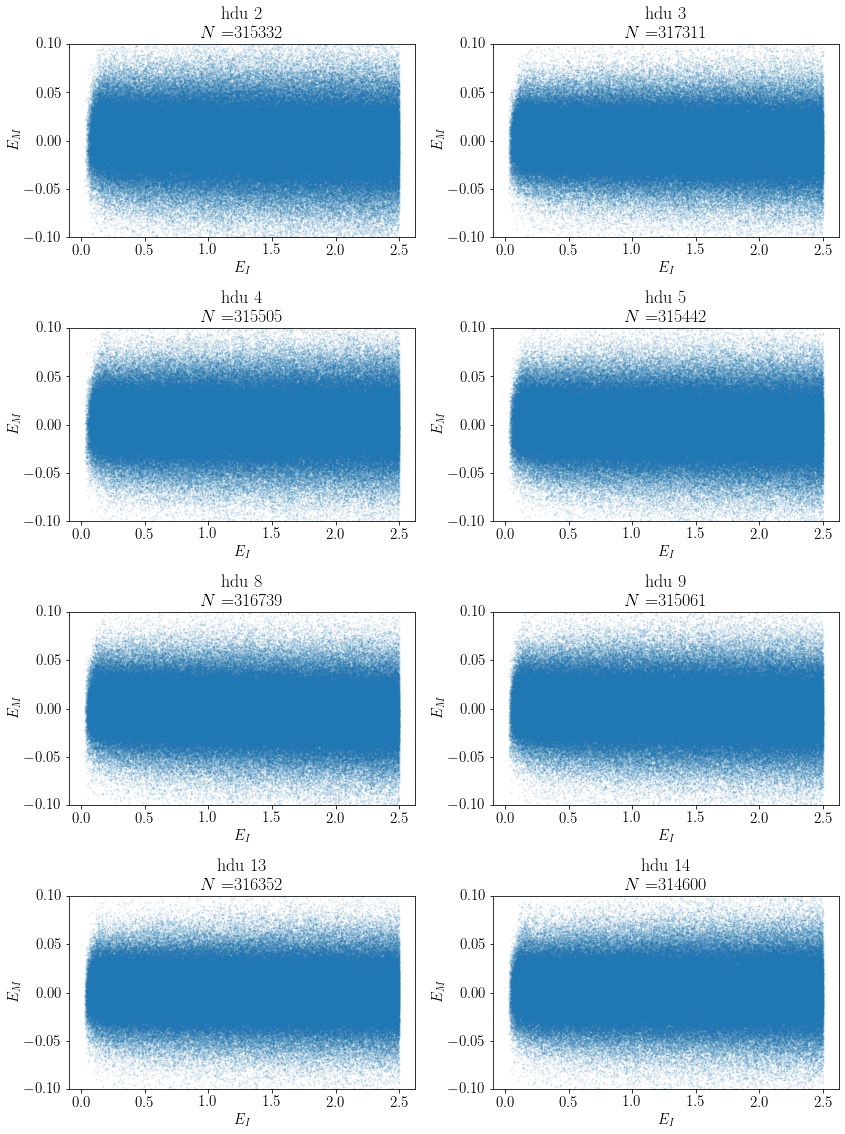

In [604]:
def dispersion_load( period, distSim=1.5 ):
    data = ia.genfromroot( 
        run2019.match_files, 
        treename="hitSumm",  
        branches = {
            "E_I": ("oEnergy", "eV"),
            "E_M": ("E1/gain3Peaks", "keV"),
            "hdu": "ohdu"
        },
        cut = str(period*run2019.excluded_ohdu*f'distSim<={distSim}'),
    )

    E_M = data["E_M"].pint.magnitude
    E_I = data["E_I"].pint.to('keV').pint.magnitude
    ohdu = data["hdu"]
    return dict(E_M=E_M, E_I=E_I, ohdu=ohdu)

def dispersion_per_ohdu( period, distSim=1.5 ):
    data = dispersion_load( period, distSim )
    return {
        ohdu: ia.np.vstack( (data["E_M"], data["E_I"]) )[:, data["ohdu"]==ohdu ] for ohdu in ia.np.unique(data["ohdu"])
    }, ["hdu", "kind", "E"]

def plot_dispersion( period, sel=slice(None, None), cols_wrap=2, distSim=1.5, func=lambda x, y: x ):
    data, dims = dispersion_per_ohdu( period, distSim )
    print( data.keys() )
    size = len(data)
    nrows, ncols = int(ia.np.ceil(size/cols_wrap)), cols_wrap
    width, height = plt.rcParams["figure.figsize"]
    fig = plt.figure( figsize = (width*ncols, height*nrows) )
    for i, (hdu, (e_M, e_I)) in enumerate( list(data.items())[sel] ):
        ax = fig.add_subplot(nrows, ncols, i+1 )
        ax.scatter( e_I, func(e_I, e_M), s=1, alpha=.1 )
        ax.set_xlabel( r"$E_I$" )
        ax.set_ylabel( r"$E_M$" )
        ax.set_title( f"hdu {hdu}\n$N=${e_M.size}" )
        ax.set_ylim((-.1, .1))
    plt.tight_layout()
    return

delta = lambda x, y: (x-y)
plot_dispersion( run2019.on_excl, distSim=1.5, func=delta )

dict_keys([2, 3, 4, 5, 8, 9, 13, 14])


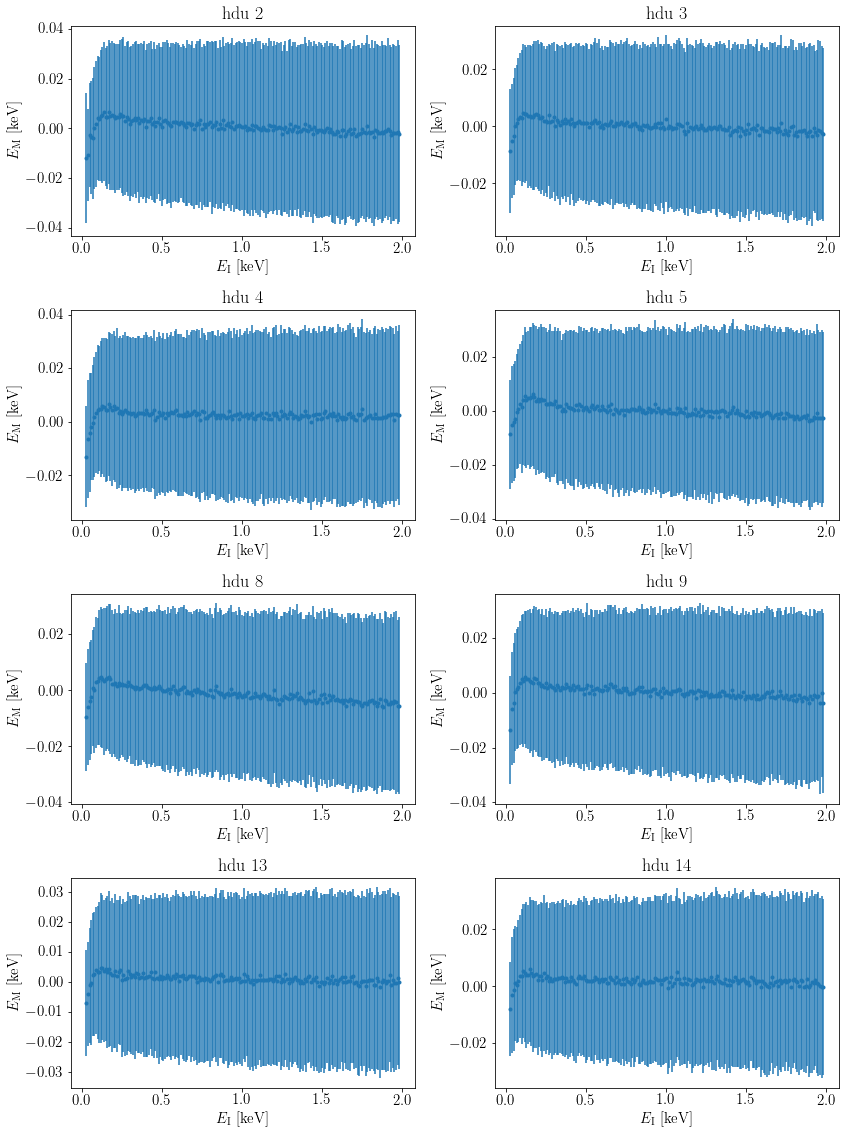

In [614]:
# @cached
def dispersion_statistics( E_I, period, distSim=1.5 ):
    data, dims = dispersion_per_ohdu( period, distSim )
    print( data.keys() )
    stats = lambda x: ( x.mean(), x.std() )
    Ebins_keV = ((E_I[:-1] + E_I[1:])/2).pint.to("keV")
    Ebins_mag = Ebins_keV.data.magnitude
    compute = lambda x, y, bins, statistics: (
        ia.binned_statistic( y[abs(y - x)<.2], (y - x)[abs(y - x)<.2], statistic=statistics, bins=bins )[0]
    )
    means = [ compute( e_M, e_I, Ebins_mag, statistics='mean' ) for i, (hdu, (e_M, e_I)) in enumerate( list(data.items()) ) ]
    stds = [ compute( e_M, e_I, Ebins_mag, statistics='std' ) for i, (hdu, (e_M, e_I)) in enumerate( list(data.items()) ) ]

    return ia.xr.DataArray(
        ia.np.dstack((means, stds)) * ureg.keV,
        dims = ["hdu", "Ei", "kind"],
        coords = {
            "kind": ["mean", "std"],
            "hdu": list(data.keys()),
            r"$E_{\rm I}$": Ebins_keV[:-1]
        }
    )

def plot_dispersion_statistics( E_I, period, cols_wrap=2 ):
    dataarray = dispersion_statistics(E_I, period )
    hdus = dataarray["hdu"].data
    size = len(hdus)
    nrows, ncols = int(ia.np.ceil(size/cols_wrap)), cols_wrap
    width, height = plt.rcParams["figure.figsize"]
    fig = plt.figure( figsize = (width*ncols, height*nrows) )
    
    for i, hdu_data in enumerate( dataarray.sel(hdu=hdus)):
        ax = fig.add_subplot(nrows, ncols, i+1 )
        means = hdu_data.sel(kind="mean")
        stds = hdu_data.sel(kind="std")
        ax.errorbar( E_I.data.to("keV").magnitude[1:-1], means.data.magnitude, yerr=stds.data.magnitude, fmt="." )
        ax.set_xlabel( E_I.name + f" [{E_I.pint.units}]" )
        ax.set_ylabel( r"$E_{\rm M}$" + f" [{E_I.pint.units}]" )
        ax.set_title( f"hdu {hdus[i]}" )
    plt.tight_layout()
    return
        
plot_dispersion_statistics( E_I, run2019.on_excl )

dict_keys([2, 3, 4, 5, 8, 9, 13, 14])
da_errorbar


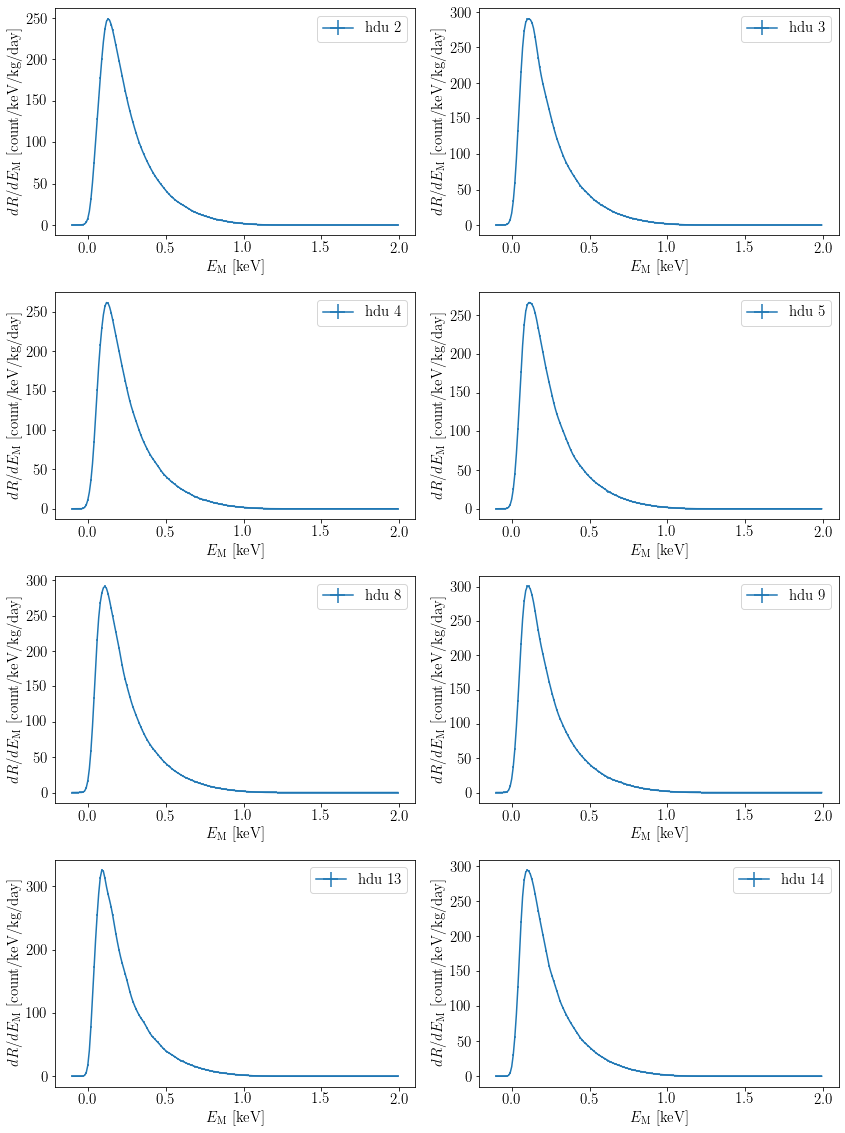

In [634]:
def dR__dE_M( E_M, E_I, flux_nu, period, func=tanhFit, p0=[10,10,10]):
    import scipy
#     import xarray as xr
    a = AdR__dE_I(E_I[1:-1], flux_nu, period, func=tanhFit, p0=[10,10,10])
    stats = dispersion_statistics(E_I, period )
    diffs = E_M - E_I[1:-1] - stats.sel(kind="mean")
    sigma = stats.sel(kind="std")
    G = scipy.stats.norm.pdf( 
        diffs.data.magnitude,
        scale=sigma.data.magnitude.T[None,:,:]
    )
    G = ia.xr.DataArray(
        G,
        dims = ["Em", "Ei", "hdu"],
        coords = {
            "hdu": stats["hdu"],
            r"$E_{\rm M}$": E_M,
            r"$E_{\rm I}$": E_I[1:-1]
        }
    )
    G.data[ia.np.isnan(G.data)] = 0

    ret = ( a*G/ureg.keV ).integrate(r"$E_{\rm I}$")
    ret.name = r"$dR/dE_{\rm M}$"
    return ret

E_M = ia.xr.DataArray( name=r"$E_{\rm M}$", data=ia.arange(-.1, 2, .01) * ureg.keV, dims = "Em" )
dR__dE_M( E_M, E_I, flux_nu, run2019.on_excl ).errorbar(
    x = E_M.name, 
    z = "hdu", 
    yunits = "count/keV/kg/day", 
    fmt = "", 
    cols_wrap = 2
);

In [ ]:
def Excess():
    

# old version

* reactor neutrino flux (cite prev paper)
* integrates to give the recoil spectrum (cite prev paper)
* uses (Youssef's) quenching factor to transform into ionization spectrum
* **extraction efficiency converts into observable spectrum**
* **convolution with energy uncertainty to get the measurable spectrum**
* **acceptance(!) to get the final expected spectrum for our selection cuts**

this last step was not performed in my analysis before. I assumed that the selection cuts would only affect with a energy-constant factor --- effective mass of the CCD. However, discussing with Guille, I realized the cuts in the region of interest are not flat and a last **acceptance** step needs to be carefully performed in a similar fashion to the efficiency correction for the extraction.

\begin{equation}
\frac{{\rm d} R }{ {\rm d} E_{\rm M} }
= {\mathcal A}(E_{\rm M})
\int_{-\infty}^{+\infty} {\rm d}E_{\rm I}
G\left(E_{\rm I} - \mu(E_{\rm M}); \sigma(E_{\rm M})\right) \epsilon(E_{\rm I}) \frac{{\rm d} R }{{\rm d} E_{\rm I} },
\end{equation}


In this notebook, the efficiency is computed. Then, the measured neutrino spectrum at CONNIE is computed based on the neutrino spectrum from the reactor. Finally, this is compared to the differential rate measured from the run2019. The result achieved is of a 95% confidence level measured rate 16 times larger than the expected neutrino rate.


## Preamble

```bash
module load py-notebook/6.1.5-gcc-8.3.0-lim66g5
module load softwares/texlive/2017
pip3 install uproot –user
pip3 install uncertainties –user
```

In [ ]:
%reload_ext autoreload
%autoreload 2

import sys, os
from glob import glob
from copy import *

from numpy import *
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic, norm, median_abs_deviation
from scipy.integrate import quad

import uproot4 as uproot
from uncertainties import *
from uncertainties import unumpy as un

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
    "image.origin": 'lower',
    "font.family": "serif",
    "font.size": 12,
    "grid.alpha": .5,
})

def O(*funcs):
    def _f(arg):
        if len(funcs) == 1:
            return funcs[-1]( arg )
        return O( *funcs[:-1] )( funcs[-1]( arg ) )
    return _f


def C(*func):
    def _f(args):
        return [ func(args) for func in funcs ]
    return _f

def mapd( func, d, key=lambda _: _):
    return dict( map( lambda kv: ( key(kv[0]), func(kv[1]) ), d.items() ) )

mad = lambda x, axis=None: median_abs_deviation(x, axis=axis)

arange2 = lambda i,f,s: arange(i,f+s,s)
binCenters = lambda bins: (bins[1:]+bins[:-1])/2.
binErrs = lambda bins: (bins[1:] - bins[:-1])/2.

In [ ]:
class Axes:
    def __init__(self, debug=False, xlabel='x', ylabel='y', title=None, 
                 xscale='linear', yscale='linear',
                 xlim=(None,None), ylim=(None,None), **kwargs):
        self.commands = []
        self.kwargs = kwargs
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.xscale = xscale
        self.yscale = yscale
        self.xlim = xlim
        self.ylim = ylim        
        self.title = title
        self.debug = debug
        self.commands.append( lambda ax: ax.set_xlabel(self.xlabel) )
        self.commands.append( lambda ax: ax.set_ylabel(self.ylabel) )
        self.commands.append( lambda ax: ax.grid(which='both') )
        if self.debug: print('init Axes')
    def __enter__(self, **kwargs):
        if self.debug: print('enter Axes')
        return self
    def __exit__(self, type, value, traceback):
        if type:
            print(type)
            print(value)
            print(traceback)
            raise type
        if self.debug: print('exiting Axes')
        self.commands.append( lambda ax: ax.legend(title=self.title) )
        self.commands.append( lambda ax: ax.set_xscale(self.xscale) )
        self.commands.append( lambda ax: ax.set_yscale(self.yscale) )
        self.commands.append( lambda ax: ax.set_xlim(*self.xlim) )
        self.commands.append( lambda ax: ax.set_ylim(*self.ylim) )
        return True
    def __getattr__(self, member):
        if self.debug: print( f'called {member}' )
        def command(*args, **kwargs):
            if self.debug: print( kwargs.keys(), self.kwargs.keys() )
            self.commands.append(
                lambda ax: getattr(ax, member)(
                    *args, **kwargs, **self.kwargs
                )
            )
            if self.debug: print( self.commands )
            return
        return command

class Figure:
    figsize = (12,6)
    number = 0
    def __init__(self, ncols=1, debug=False, **kwargs):
        self.axes = []
        self.ncols = ncols
        self.debug = debug
        if self.debug: print('init Figure')
    def __enter__(self):
        if self.debug: print('enter Figure')
        return self
    def __exit__(self, type, value, traceback):
        if type:
            print(type)
            print(value)
            print(traceback)
            raise type
            
        if self.debug: print( 'number of axes', len(self.axes) )
        nrows = int( len(self.axes)/self.ncols ) + 1
        if self.debug: print( 'nrows', nrows )
        fig = plt.figure(figsize=(
            Figure.figsize[0], 
            Figure.figsize[1]*nrows
        ))
        for i, axis in enumerate(self.axes):
            if self.debug: print('command', i)
            ax = fig.add_subplot(nrows, self.ncols, i+1)
            for command in axis.commands:
                if self.debug: print('command', command)
                command(ax)
        Figure.number += 1
        print(f'Figure [{Figure.number}]')
        plt.show()
        if self.debug: print('exiting Figure')
        return True
    def addAxes(self, **kwargs):
        ax = Axes(debug=self.debug, **kwargs)
        self.axes.append( ax )
        if self.debug: 
            print('number of axes', len(self.axes), kwargs.keys() )
        return ax

In [ ]:
class BinnedSpectrum(ndarray):
    def __new__(cls, array, bins):
        obj = asarray(array).view(cls)
        obj.bins = bins
        return obj
        
    def __finalize_array__(self, obj):
        if obj is None: return
        self.bins = obj.bins
    
    def plot(self, ax, **kwargs):
        ax.errorbar( 
            self.binCenters(), 
            y=self.n(), 
            xerr=self.bins[2]/2., 
            yerr=self.s(), 
            fmt=' ', 
            **kwargs 
        )

    def n(self):
        return un.nominal_values(self)
    
    def s(self):
        return un.std_devs(self)
    
    def binEdges(self):
        return arange2(*self.bins)

    def binCenters(self):
        bins = self.binEdges()
        return .5*(bins[1:]+bins[:-1])
    
    def __truediv__(self, a):
        ret = array(self)
        b = array(a)
        ret[b>0] /= b[b>0]
        return BinnedSpectrum(ret, self.bins)
    
    def __add__(self, a):
        print('add')
        return BinnedSpectrum( 
            array(self) + array(a), 
            self.bins
        )

    def __sub__(self, a):
        return BinnedSpectrum( 
            array(self) - array(a), 
            self.bins
        )

    def __mul__(self, a):
        return BinnedSpectrum( array(self) * array(a), self.bins)
        
    def fit_params(self, func, p0):
        popt = curve_fit( func, self.binCenters(), un.nominal_values(self), p0=p0 )[0]
        return popt
    
    def fit_func(self, func, p0):
        return lambda x: func(x, *self.fit_params(func, p0))
    
    def plot_fit(self, ax, func, p0, **kwargs):
        x = self.binCenters()
        ax.plot( x, self.fit_func(func,p0)(x), **kwargs)
    
    def interp(self, **kwargs):
        return interp1d(self.binCenters(), self.n(), bounds_error=False, fill_value='extrapolate', **kwargs)
    
    @classmethod
    def fromCatalogs(cls, pattern, branch, bins, weights=None, cut=None, statistic='count', debug=False, yerrFunc = sqrt):
        values = uproot.concatenate(pattern, expressions=branch, cut=cut, library='np')[branch]
        if debug: print( 'values', values )
        w = ones_like(values)
        if weights:
            w = uproot.concatenate(pattern, expressions=weights, cut=cut, library='np')[weights]
        y = binned_statistic( values, w, bins=arange2(*bins), statistic=statistic )[0].astype(float)
        if statistic == 'mean':
            yerr = binned_statistic( values, w, bins=arange2(*bins), statistic='std' )[0].astype(float)
        else:
            yerr = sqrt(y)
        return BinnedSpectrum( un.uarray(y, yerr), bins )
    
    @classmethod
    def fromFunc(cls, func, bins, epsrel=1e-4):
        x = arange2(*bins)
        y = array( [ quad( func, x[i], x[i+1], epsrel=epsrel )[0]/(x[i+1]-x[i]) 
                         for i in range(len(x)-1) ] )
        return BinnedSpectrum( un.uarray(y, 0), bins )

def printtable( *specs, xlabel='x', ylabels=['y'], fmt='uf' ):
    
    x = list(map(lambda s: f'{s}', specs[0].binEdges()[:-1]))
    xlen = max(map(len, x))

    y = [ list(map(lambda s: ('{:.1%s}'%fmt).format(s), spec)) for spec in specs ]
    ylen = [ max(map(len, _y)) for _y in y ]

    format_str = '{:<%s} | '%xlen
    format_str += ' | '.join( [ '{:<%s}'%_ylen for _ylen in ylen ] )
    
    print( format_str.format(xlabel, *ylabels) )
    print( '='*( xlen + sum(ylen) + 3*len(ylabels) ) )
    x = list(map(lambda s: ('{:>%s}'%(xlen)).format(s), x))
    y = [ list(map(lambda s: ('{:>%s}'%(_ylen)).format(s), _y)) for _y, _ylen in zip(y,ylen) ]

    table = list( zip(x, *y) )
    print( '\n'.join(map(lambda s: ' | '.join(s), table) ) )
    print( '='*( xlen + sum(ylen) + 3*len(ylabels) ) )

def nom( kernel, func, epsrel=1e-2, lims=(0, inf) ):
    return vectorize( lambda new_x: quad( 
        lambda x: kernel(new_x, x)*func(x), lims[0], lims[1], epsrel=epsrel 
    )[0] )

def den( kernel, epsrel=1e-2, lims=(0, inf) ):
    return vectorize( lambda new_x: quad( 
        lambda x: kernel(new_x, x), lims[0], lims[1], epsrel=epsrel 
    )[0] )

def convolveFuncs( kernel, func, epsrel=1e-2, lims=(0, inf) ):
    nomf = nom( kernel, func, epsrel=epsrel, lims=lims )
    denf = den( kernel, epsrel=epsrel, lims=lims)
    return lambda x: nomf(x)/denf(x)

In [ ]:
pattern = {
    'match': '/share/storage2/connie/DAna/nuCatalogs/match_*_sim_[6-7]*_to_*_v4.0.root',
    'data': '/share/storage2/connie/DAna/nuCatalogs/shape_*_data_[6-7]*_to_*_v4.0.root',    
    'sim': '/share/storage2/connie/DAna/nuCatalogs/draw_all*.root',
}
OHDUs = [2,3,4,5,8,9,13,14]

In [ ]:
class FuncDict:
    def __init__(self, func):
        self.func = func
        self.d = {}
    
    def __getitem__(self, arg):
        if not arg in self.d:
            self.d[arg] = func(arg)
        return self.d[arg]

# Neutrino ionization rate

After converting the recoil spectrum to the ionization spectrum using the quenching factor, one gets the ionization rate

$$
\frac{{\rm d}R}{{\rm d}E_I}
$$

# measured energy

the measured energy is not the same as the ionization energy due to the extraction algorithm and the dark current that accumulates in each track.

### mean energy shift

In [ ]:
dispersion = lambda ohdu: uproot.concatenate(f'{pattern["match"]}:hitSumm', expressions=['E1/gain3Peaks*1e3', 'oEnergy'], cut=f'(ohdu=={ohdu}) & (distSim<1.5)', library='np')

with Figure() as fig:
    with fig.addAxes(ylabel='mean ionization energy [eVee]', xlabel='measured energy [eVee]', title=r'$\mu(E_{\rm M})$', xlim=(0,200), ylim=(0,200)) as ax:
        ax.scatter( dispersion(2)['E1/gain3Peaks*1e3'], dispersion(2)['oEnergy'], s=1 )

\begin{equation}\label{eq:muFit}
\mu(E_{\rm M}) = a \frac{ (E_{\rm M} + d )^2 + c }{ E_{\rm M} + b }
\end{equation}


In [ ]:
mu = {}
mu['M'] = {}
mu_M = lambda ohdu: BinnedSpectrum.fromCatalogs(f'{pattern["match"]}:hitSumm', 'E1/gain3Peaks*1e3', (0, 600, 10), 
                         weights='oEnergy', cut=f'(ohdu=={ohdu}) & (distSim<1.5)', statistic='mean' )
for ohdu in OHDUs:
    mu['M'][ohdu] = mu_M(ohdu)

mufit_func = lambda x, *p: p[0]*((x-p[3])**2 + p[1])/(x + p[2])
mu_p0 = [1,1,1,1]
with Figure() as fig:
    with fig.addAxes(ylabel='mean ionization energy [eVee]', xlabel='measured energy [eVee]', title=r'$\mu(E_{\rm M})$', xlim=(0,200), ylim=(0,200)) as ax:
        mu['M'][2].plot(ax, label=r'least efficient', color=colorLeast)
        mu['M'][13].plot(ax, label=r'most efficient', color=colorMost)        
#         print( mu['M'][2].fit_params(mufit_func, p0=mu_p0) )
        mu['M'][2].plot_fit(ax, mufit_func, p0=mu_p0, label=r'', color=colorLeast)
#         print( mu['M'][13].fit_params(mufit_func, p0=mu_p0) )
        mu['M'][13].plot_fit(ax, mufit_func, p0=mu_p0, label=r'', color=colorMost)

for ohdu in OHDUs:
    print( mu['M'][ohdu].fit_params(mufit_func, p0=mu_p0) )
    
# with Figure() as fig:
#     with fig.addAxes(ylabel='mean ionization energy [eVee]', xlabel='measured energy [eVee]', title=r'$\mu(E_{\rm M})$', xlim=(0,200), ylim=(0,200)) as ax:
#         for ohdu in [2,3,4,5,8,9,13,14]:
#             mu['M'][ohdu].plot(ax, label=f'ohdu{ohdu}')
#             mu['M'][ohdu].plot_fit(ax, mufit_func, p0=mu_p0, label=r'')


### energy dispersion

\begin{equation}\label{eq:sigmaFit}
\sigma( E_{\rm M} ) = a \log\left( \frac{E_{\rm M}-c}{b} \right)
\end{equation}


In [ ]:
sigma = {}
sigma['M'] = {}
sigma_M = lambda ohdu: BinnedSpectrum.fromCatalogs(f'{pattern["match"]}:hitSumm', 'E1/gain3Peaks*1e3', (0, 600, 10), 
                         weights='oEnergy', cut=f'(ohdu=={ohdu}) & (distSim<1.5)', statistic='std', yerrFunc = lambda x: 0 )
for ohdu in OHDUs:
    sigma['M'][ohdu] = sigma_M(ohdu)

sigmafit_func = lambda x, *p: p[0]*log((x-p[2])/p[1])
sigma_p0 = [1,1,0]

with Figure() as fig:
    with fig.addAxes(ylabel='dispersion in ionization energy [eVee]', xlabel='measured energy [eVee]', title=r'$\sigma(E_{\rm M})$') as ax:
        sigma['M'][2].plot(ax, label=r'least efficient', color=colorLeast)
        sigma['M'][13].plot(ax, label=r'most efficient', color=colorMost)
        print( sigma['M'][2].fit_params(sigmafit_func, p0=sigma_p0) )
        sigma['M'][2].plot_fit(ax, sigmafit_func, p0=sigma_p0, label=r'', color=colorLeast)
        print( sigma['M'][13].fit_params(sigmafit_func, p0=sigma_p0) )
        sigma['M'][13].plot_fit(ax, sigmafit_func, p0=sigma_p0, label=r'', color=colorMost)

for ohdu in OHDUs:
    print( sigma['M'][ohdu].fit_params(sigmafit_func, p0=sigma_p0) )
    
# with Figure() as fig:
#     with fig.addAxes(ylabel='dispersion in ionization energy [eVee]', xlabel='measured energy [eVee]', title=r'$\sigma(E_{\rm M})$') as ax:
#         for ohdu in OHDUs:
#             sigma['M'][ohdu].plot(ax, label=f'ohdu{ohdu}')
#             sigma['M'][ohdu].plot_fit(ax, sigmafit_func, p0=sigma_p0, label=r'')


# Rate in measured energy

Now the rate is converted to the measured energy by convolving the rate with a gaussian distribution for each measured energy bin.

<!-- $$
\frac{{\rm d} R'(E_{\rm M})}{{\rm d} E_{\rm M} } = 
\frac{1}{W(E_{\rm M})}
\int_{0}^\infty {\rm d}E_{\rm I}\,G \left( E_{\rm I} - \mu(E_{\rm M}); \sigma(E_{\rm M}) \right) \frac{{\rm d} R'(E_{\rm I})}{{\rm d} E_{\rm I} },
$$
 -->
$$
\frac{{\rm d} R'(E_{\rm M})}{{\rm d} E_{\rm M} } = 
\int_{-\infty}^\infty {\rm d}E_{\rm I}\,G \left( E_{\rm I} - \mu(E_{\rm M}); \sigma(E_{\rm M}) \right) \frac{{\rm d} R'(E_{\rm I})}{{\rm d} E_{\rm I} },
$$

<!-- where the normalization is,

$$
W(E_{\rm M}) = \int_0^\infty {\rm d}E_{\rm I}\,G \left( E_{\rm I} - \mu(E_{\rm M}); \sigma(E_{\rm M}) \right).
$$
 -->
it is important that the gaussian parameters do not depend in the integrand ─ the ionization energy ─ to assure it is a gaussian convolution.

In [ ]:
kernel = lambda ohdu, E_new, E: norm.pdf(E, loc=mu['M'][ohdu].interp()(E_new), scale=sigma['M'][ohdu].interp()(E_new) )

E = arange(30, 600, 10)
dR_dE['1x5']['M'] = {}
dR_dE['1x5']['M'][2] = interp1d( E, convolveFuncs( 
    lambda e, ee: kernel(2, e, ee), lambda e: dR_dE['1x5']['I*'](2, e), lims=(30,600)
)(E))
dR_dE['1x5']['M'][13] = interp1d( E, convolveFuncs(
    lambda e, ee: kernel(13, e, ee), lambda e: dR_dE['1x5']['I*'](13, e), lims=(30,600)
)(E))

In [ ]:
with Figure(ncols=1) as fig:
    for yscale in ['linear']:#, 'log']:
        with fig.addAxes(xlabel='energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                         title='measured energy', ylim=(0,50), yscale=yscale) as ax:
            ax.plot( E, dR_dE['1x5']['I*'](2, E), label=r'ionization', color=colorLeast )
            ax.plot( E, dR_dE['1x5']['M'][2](E), label=r'measured', color=colorLeast)
            ax.plot( E, dR_dE['1x5']['I*'](13, E), label=r'ionization', color=colorMost)
            ax.plot( E, dR_dE['1x5']['M'][13](E), label=r'measured', color=colorMost)


In [ ]:
mu_fit = {}
for ohdu in OHDUs:
    mu_fit[ohdu] = mu['M'][ohdu].fit_func(mufit_func, p0=mu_p0)

sigma_fit = {}
for ohdu in OHDUs:
    sigma_fit[ohdu] = sigma['M'][ohdu].fit_func(sigmafit_func, p0=sigma_p0)

kernel_fit = {}
for ohdu in OHDUs:
    kernel_fit[ohdu] = lambda e_new, e: norm.pdf(e, loc=mu_fit[ohdu](e_new), scale=sigma_fit[ohdu](e_new) )

E = arange(30, 600, 10)
dR_dE['1x5fit'] = {}
dR_dE['1x5fit']['M'] = {}
for ohdu in OHDUs:
    dR_dE['1x5fit']['M'][ohdu] = interp1d( E, convolveFuncs( 
        kernel_fit[ohdu], lambda e: dR_dE['1x5']['I*'](ohdu, e), lims=(30,600)
    )(E))


In [ ]:
with Figure(ncols=1) as fig:
    for yscale in ['linear']:#, 'log']:
        with fig.addAxes(xlabel='energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                         title='measured energy', ylim=(0,50), yscale=yscale) as ax:
            ax.plot( E, dR_dE['1x5']['I*'](2, E), label=r'', ls='--', color=colorLeast )
            ax.plot( E, dR_dE['1x5fit']['M'][2](E), label=r'least efficient', color=colorLeast)
            ax.plot( E, dR_dE['1x5']['I*'](13, E), label=r'', ls='--', color=colorMost)
            ax.plot( E, dR_dE['1x5fit']['M'][13](E), label=r'most efficient', color=colorMost)


# acceptance

the rates in measured energy need to be converted to what is actually measured in our experiment in order to compare to data. Therefore, the acceptance ─ from the selection cuts ─ need to be taken into account. 

\begin{equation}\label{eq:acceptance}
    \mathcal{A}(E_{\rm M})
    =
    \frac{a_2 E_{\rm M}^2 + a_1 E_{\rm M} + a_0 }{ E_{\rm M}^2 + b_1 E_{\rm M} + b_0 }
\end{equation}


In [ ]:
matchDistMax=1.5
selection = {}
selection['size'] = '(sizell<.95) & (sizell>0)'
selection['energy'] = '(E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50)'
selection['geom'] = '(xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)'
# selection['runIDoff'] = '(runID>6226) & (runID<6975)'

selection['sim'] = lambda ohdu: ' & '.join( [f'hdu=={ohdu}'] )
selection['match'] = lambda ohdu: ' & '.join( [
    f'(ohdu=={ohdu}) & (distSim < {matchDistMax})', 
#     selection['runIDoff'],
] )
selection['matchSel'] = lambda ohdu: ' & '.join( [
    f'(ohdu=={ohdu}) & (distSim < {matchDistMax})', 
    selection['size'],
    selection['energy'],
    selection['geom'],
#     selection['runIDoff']
] )


Ebins = (50, 2500, 5)

dN_dE_M = {}
acceptance = {}
for ohdu in OHDUs:
    dN_dE_M[ohdu] = {}
#     dN_dE_M[ohdu]['sim'] = BinnedSpectrum.fromCatalogs( f'{pattern["sim"]}:hitSumm', 'oEnergy',
#         cut=selection['sim'](ohdu), bins=Ebins )
    dN_dE_M[ohdu]['match'] = BinnedSpectrum.fromCatalogs( f'{pattern["match"]}:hitSumm', 'E1/gain3Peaks*1e3',
        cut=selection['match'](ohdu), bins=Ebins )
    dN_dE_M[ohdu]['matchSel'] = BinnedSpectrum.fromCatalogs( f'{pattern["match"]}:hitSumm', 'E1/gain3Peaks*1e3',
        cut=selection['matchSel'](ohdu), bins=Ebins )
    # 
    acceptance[ohdu] = dN_dE_M[ohdu]['matchSel']/dN_dE_M[ohdu]['match']


In [ ]:
e = arange2(0, 2500, 10)

# acceptance_fit = lambda x, *p: p[0] *( 
#     ((tanh( (x-p[1])/p[2] ) + 1)/2)**10
# )
acceptance_fit = lambda x, *p: ( 
    (p[0]*x**2 + p[1]*x + p[2])/(x**2 + p[3]*x + p[4])
)
p0 = [1, 1, 1, 1, 1] #, 100, 100, 
      #1]

for ohdu in OHDUs:
    print( 
        ohdu, '&',
        ' & '.join(map( lambda line: '%f'%line,
            acceptance[ohdu].fit_params( acceptance_fit, p0=p0 ) 
        ))
    )

with Figure(ncols=1) as fig:
    with fig.addAxes(xlabel='energy [eVee]', ylabel='acceptance', title='acceptance', xlim=(50,500)) as ax:
        acceptance[2].plot( ax, label='least efficient', color=colorLeast )
        acceptance[2].plot_fit( ax, acceptance_fit, p0=p0, label=r'', color=colorLeast )
#         for e, i in zip(acceptance[2].binCenters(), acceptance[2]):
#             print( e, i.n )
        
        acceptance[13].plot( ax, label='most efficient', color=colorMost )
        acceptance[13].plot_fit( ax, acceptance_fit, p0=p0, label=r'', color=colorMost )


this means that around 30% of the active area of the CCD is excluded by our selection cuts. And it is also explicit that this effect is not constant in energy for the region of interest

In [ ]:
with Figure(ncols=1) as fig:
    for yscale in ['linear']:
        with fig.addAxes(xlabel='energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                         title='acceptance correction', xlim=(50,500), ylim=(0,40), yscale=yscale) as ax:


            ax.plot( E, dR_dE['1x5fit']['M'][2](E), label=r'', color=colorLeast, ls='--')
            ax.plot( E, dR_dE['1x5fit']['M'][2](E)*acceptance[2].fit_func(acceptance_fit, p0=p0)(E), label=r'least efficient', color=colorLeast)

            ax.plot( E, dR_dE['1x5fit']['M'][13](E), label=r'', color=colorMost, ls='--')
            ax.plot( E, dR_dE['1x5fit']['M'][13](E)*acceptance[13].fit_func(acceptance_fit, p0=p0)(E), label=r'most efficient', color=colorMost)

            

In [ ]:
with Figure(ncols=1) as fig:
    for yscale in ['log']:
        with fig.addAxes(xlabel=r'$E_{\rm M}$ [eVee]', ylabel=r'$dR/dE_{\rm M}$ [events/kg/day/keV]', 
                         title='expected rate', xlim=(50, 400), ylim=(1, 100), yscale=yscale) as ax:


#             ax.plot( E, dR_dE['1x5fit']['M'][2](E), label=r'', color=colorLeast, ls='--')
            ax.plot( E, dR_dE['1x5fit']['M'][2](E)*acceptance[2].fit_func(acceptance_fit, p0=p0)(E), label=r'least efficient', color=colorLeast)

#             ax.plot( E, dR_dE['1x5fit']['M'][13](E), label=r'', color=colorMost, ls='--')
            ax.plot( E, dR_dE['1x5fit']['M'][13](E)*acceptance[13].fit_func(acceptance_fit, p0=p0)(E), label=r'most efficient', color=colorMost)

            

In [ ]:
with Figure(ncols=1) as fig:
    for yscale in ['log']:
        with fig.addAxes(xlabel=r'$E_{\rm M}$ [eVee]', ylabel=r'$dR/dE_{\rm M}$ [events/kg/day/keV]', 
                         title='expected rate', xlim=(50, 400), ylim=(1, 100), yscale=yscale) as ax:

            average_dR_dE = mean( [ dR_dE['1x5fit']['M'][ohdu](E)*acceptance[ohdu].fit_func(acceptance_fit, p0=p0)(E) for ohdu in OHDUs ], axis=0 )
            ax.plot( E, average_dR_dE, label=r'least efficient', color=colorLeast )
            

# binning

The rate is integrated into bins for 

In [ ]:
# for binsize in [200, 130, 50]:
for binsize in [130]:
    bins = (50, 430, binsize)
    with Figure(ncols=1) as fig:
        for yscale in ['linear']:
            with fig.addAxes(xlabel='measured energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                             title=fr'expected $\nu$ rate\n $\Delta E={binsize}$eV', yscale=yscale, ylim=(0,30)) as ax:
                
                ax.plot( E, dR_dE['1x5fit']['M'][2](E)*acceptance[2].fit_func(acceptance_fit, p0=p0)(E), label=r'', color=colorLeast)
                r2 = BinnedSpectrum.fromFunc(
                    lambda e: dR_dE['1x5fit']['M'][2](e)*acceptance[2].fit_func(acceptance_fit, p0=p0)(e)
                    , bins )
                r2.plot(ax, label=f'least efficient', color=colorLeast)
                print( r2 )

                ax.plot( E, dR_dE['1x5fit']['M'][13](E)*acceptance[13].fit_func(acceptance_fit, p0=p0)(E), label=r'', color=colorMost)
                r13 = BinnedSpectrum.fromFunc(
                    lambda e: dR_dE['1x5fit']['M'][13](e)*acceptance[13].fit_func(acceptance_fit, p0=p0)(e)
                    , bins )
                r13.plot(ax, label=f'most efficient', color=colorMost)
            
        printtable(r2, r13, xlabel='E', ylabels=['eff-', 'eff+'], fmt='f')


# ON–OFF 2019

In this section, the reactor ON and OFF data are selected using the agreed runID, geometric, energy and event-size selection cuts. These are defined below.

### selection cuts

In [ ]:
runIDexcluded = [6415, 6475, 6499, 6926, 6927, 6031, 6093, 6096, 6139, 7074, 7222, 7226, 7374]
selection = {}
selection['runID'] = ' & '.join(map(lambda s: f'(runID!={s})', runIDexcluded))

selection['size'] = '(sizell<.95) & (sizell>0)'
selection['energy'] = '(E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50)'
selection['geom'] = '(xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)'
selection['ohdu'] = '(' + ' | '.join(map(lambda s: f'(ohdu=={s})', [2,3,4,5,8,9,13,14])) + ')'

selection['runIDon'] = '( ((runID>6030) & (runID<6227)) | ((runID>6974) & (runID<7522)) )'
selection['runIDoff'] = '(runID>6226) & (runID<6975)'


In [ ]:

selection['on'] = lambda ohdu: ' & '.join( [
    selection['runID'], 
    selection['size'], 
    selection['energy'], 
    selection['geom'],
    selection['ohdu'],
    selection['runIDon'],
    f'(ohdu=={ohdu})'
] )
selection['off'] = lambda ohdu: ' & '.join( [
    selection['runID'], 
    selection['size'], 
    selection['energy'], 
    selection['geom'],
    selection['ohdu'],
    selection['runIDoff'],
    f'(ohdu=={ohdu})'
] )

In [ ]:
if not "dN_dE" in globals():
    dN_dE = {}

dN_dE['on'] = {}
dN_dE['off'] = {}
Ebins = (50, 9200, 130)
dN_dE['on'][3] = BinnedSpectrum.fromCatalogs(
    f'{pattern["data"]}:hitSumm', 'E1/gain3Peaks*1e3', cut=selection['on'](3), bins=Ebins
)
dN_dE['off'][3] = BinnedSpectrum.fromCatalogs(
    f'{pattern["data"]}:hitSumm', 'E1/gain3Peaks*1e3', cut=selection['off'](3), bins=Ebins
)

nImages = {}
nImages['on'] = unique(uproot.concatenate(
    f'{pattern["data"]}:hitSumm', 'runID', library='np', cut=selection['on'](3)
)['runID'])
nImages['off'] = unique(uproot.concatenate(
    f'{pattern["data"]}:hitSumm', 'runID', library='np', cut=selection['off'](3)
)['runID'])

### convert to rate (mass and exposure)

In [ ]:
dT = {}
rho = 2.42*1e-3*(1e2)**3 #kg/m^3
dM = rho * (15*1e-6)**2 * 675*1e-6 * 4120**2
print('mass', dM, dM*len(OHDUs), len(OHDUs))
dT['on'] = len(nImages['on'])/24
print( 'days on', dT['on'] )
dT['off'] = len(nImages['off'])/24
print( 'days off', dT['off'] )

In [ ]:
if not "dR_dE" in globals():
    dR_dE = {}

dR_dE['on'] = {}
dR_dE['off'] = {}

for ohdu in OHDUs:
    dN_dE['on'][ohdu] = BinnedSpectrum.fromCatalogs(
        f'{pattern["data"]}:hitSumm', 
        'E1/gain3Peaks*1e3', 
        cut=selection['on'](ohdu), 
        bins=Ebins
    )
    dN_dE['off'][ohdu] = BinnedSpectrum.fromCatalogs(
        f'{pattern["data"]}:hitSumm', 
        'E1/gain3Peaks*1e3', 
        cut=selection['off'](ohdu), 
        bins=Ebins
    )
    
    dR_dE['on'][ohdu] = dN_dE['on'][ohdu]/dT['on']/dM/(1e-3*Ebins[-1])
    dR_dE['off'][ohdu] = dN_dE['off'][ohdu]/dT['off']/dM/(1e-3*Ebins[-1])
    
def bmean( args, axis=None ):
    bins = args[0].bins
    m = mean( list(map(array, args)), axis=axis )
    return BinnedSpectrum(m, bins)

def baverage( args, axis=None, return_weights=False, weights=None ):
    bins = args[0].bins
    if weights is None:
        stds = array(list(map(lambda x: array(x.s()), args)))
        weights = 1./stds**2
        weights = weights
    values = array(list(map(array, args)))
    ave = sum( weights*values, axis=axis)/sum(weights, axis=axis)
    if return_weights:
        return BinnedSpectrum(ave, bins), weights
    return BinnedSpectrum(ave, bins)


In [ ]:
with Figure(ncols=1) as fig:
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title='measured rates'
    ) as ax:
        baverage(
            [ dR_dE['on'][ohdu] for ohdu in OHDUs ], 
            axis=0
        ).plot(ax, label='ON')
        baverage(
            [ dR_dE['off'][ohdu] for ohdu in OHDUs ], 
            axis=0
        ).plot(ax, label='OFF')


At this point, all the OHDU rates are generated and shown below.

In [ ]:
with Figure(ncols=2) as fig:
    for ohdu in OHDUs:
        with fig.addAxes(
            xlabel='measured energy [eVee]', 
            ylabel='rate [events/kg/day/keV]',
            title=f'OHDU{ohdu}'
        ) as ax:
            diff = dR_dE['on'][ohdu] - dR_dE['off'][ohdu]
            diff.plot(ax, label=r'ON–OFF')


The combined differential rate is obtained by taking the weighted average of all the OHDUs. For comparison, the mean is also computed.

In [ ]:
aveDiff, weights = baverage(
    [ dR_dE['on'][ohdu] - dR_dE['off'][ohdu] for ohdu in OHDUs ], 
    axis=0,
    return_weights=True
#     extras = [ 
#         BinnedSpectrum.fromFunc(
#             lambda e: dR_dE['1x5fit']['M'][ohdu](e)*acceptance[ohdu].fit_func(acceptance_fit, p0=p0)(e), new_bins 
#         ) for ohdu in [2,3,4,5,8,9,13,14] 
#     ], 
)
print( weights.shape )

new_bins = list(aveDiff.bins)
new_bins[1] = 400
binnedRate = {}
# for ohdu in OHDUs:
#     binnedRate[ohdu] = BinnedSpectrum.fromFunc(
#         lambda e: dR_dE['1x5fit']['M'][ohdu](e)*acceptance[ohdu].fit_func(acceptance_fit, p0=p0)(e), 
#         new_bins )

# binnedRateAve = baverage(
#     [ binnedRate[ohdu] for ohdu in OHDUs ],
#     axis=0,
#     weights=weights[:,:3]
# )

Below, the combined differential rate is compared with the expected neutrino rate obtained in the previous section. At the bottom, the 95% confidence level rate is shown also.

# differential rate

In [ ]:
oneSideCL = 1.64
aveDiff95CF = BinnedSpectrum( array(aveDiff.n()) + oneSideCL*array(aveDiff.s()), aveDiff.bins )

with Figure() as fig:
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title=f'differential rate'
    ) as ax:
        aveDiff.plot(ax, label=r'ON ─ OFF')
#         binnedRate2.plot(ax, label='Juan2')
#         binnedRate13.plot(ax, label='Juan13')
#     with fig.addAxes(
#         xlabel='measured energy [eVee]', 
#         ylabel='rate [events/kg/day/keV]',
#         title=f'OHDU{ohdu}\n95% CF'
#     ) as ax:
#         aveDiff95CF.plot(ax, label=r'ON–OFF weightd')
#         binnedRate2.plot(ax, label='Juan2')
#         binnedRate13.plot(ax, label='Juan13')
with Figure() as fig:
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title=f'differential rate\n95% CF',
        xlim=(0,400),
        ylim=(0,1000)
    ) as ax:
        aveDiff95CF.plot(ax, label=r'ON ─ OFF')
#         binnedRate[2].plot(ax, label='least efficient')
#         binnedRate[13].plot(ax, label='most efficient')


In blue, the mean differential rates. In orange, the weighted averages and in green the expected rates.

Below, the table with the values are presented for the energy range of interest. Also, the ratio between the 95% confidence level of the measurement and the expected rate. The 95% CF level measument is 16 times larger than the expected rate. This is a significant increase in comparison with the 40 times result achieved in the previous paper.

# comparison with expected rate

In [ ]:
# meanDiff95CF3 = BinnedSpectrum( meanDiff95CF[:3], binnedRate.bins )
aveDiff95CF3 = BinnedSpectrum( aveDiff95CF[:3], binnedRate2.bins )

binnedRate_2 = BinnedSpectrum( array(binnedRate[2].n()), binnedRate[2].bins )
binnedRate_13 = BinnedSpectrum( array(binnedRate[13].n()), binnedRate[13].bins )
binnedRate_Ave = BinnedSpectrum( array(binnedRateAve.n()), binnedRateAve.bins )
printtable( 
    aveDiff95CF3, 
    binnedRate_2, 
    binnedRate_13,
    binnedRate_Ave,
#     aveDiff95CF3/binnedRate_2, 
#     aveDiff95CF3/binnedRate_13, 
    xlabel='E', 
    ylabels=['95%CF', 'rate2', 'rate13', 'rateAve'#'ratio2', 'ratio13'
            ], 
    fmt='f' 
)

with Figure(ncols=1) as fig:
    with fig.addAxes(
        xlabel='energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title=f'95% CL',
        yscale='log'
    ) as ax:
        aveDiff95CF3.plot(ax, label=r'ON–OFF')
#         binnedRate[2].plot(ax, label='rate2')
#         binnedRate[13].plot(ax, label='rate13')
        binnedRateAve.plot(ax, label='expected rate')



In [ ]:
print( aveDiff95CF3 )

# Advanced version

In [ ]:
def get_array( file, expressions=None,  ):
    return uproot.concatenate( f'{pattern["data"]}:hitSumm', expressions=expressions, cut=cut )['runID']

In [ ]:
def print_header(func):
    def wrapper(*args, **kwargs):
        print( f"{args[0].__class__.__name__}.{func.__name__}" )
        return func(*args, **kwargs)
    return wrapper

def safediv(a, b):
    ret = zeros_like( a )
    ret[ a!=0 ] = a[ a!=0 ]/b[ a!=0 ]
    return ret

def composekwargs(f, g):
    return lambda **kwargs: f(g(**kwargs), **kwargs)


In [ ]:
from numpy import *
import types
import uproot4 as uproot
import matplotlib.pyplot as plt
from copy import deepcopy

class LazyPlottable:
    def __init__(self):
        pass
    
    def plot(self, label=None, fig=None, ax=None, **kwargs):
        show = False
        if ax is None:
            if fig is None:
                print("create figure")
                fig = plt.figure()
                show = True
            print("create axis")
            ax = fig.add_subplot()
        ax.grid(True)
        if not "dx" in kwargs:
            raise Exception("needs dx argument")
        if not "xlabel" in kwargs:
            ax.set_xlabel( self.xlabel(**kwargs) )
        if not "xlabel" in kwargs:
            ax.set_ylabel( self.ylabel(**kwargs) )
        if "yscale" in kwargs:
            ax.set_yscale(kwargs["yscale"])

        ax.errorbar( 
            self.x(**kwargs), 
            self.y(**kwargs), 
            xerr=self.xerr(**kwargs), 
            yerr=self.yerr(**kwargs), 
            label=self.label(**kwargs), 
            fmt=' ' 
        )
        
        if show:
            plt.legend()
            plt.show()
        return self

    

In [ ]:
pattern = '/share/storage2/connie/DAna/nuCatalogs/shape_*_data_[6-7]*_to_*_v4.0.root'
class SelectedData(LazyPlottable):
    def __init__(self, label, selections):
        self._initlabel = label
        self.selections = selections
        self.funclist = [self.load_data]
        self.kwargs = None
        
    def load_data(self, **kwargs):
        if not hasattr(self, "data"):
            print(f"load data {self._initlabel}")
            self.ohdus = kwargs["ohdus"]
            self.cuts = kwargs["cuts"]
            ohdu_cuts = list(map(lambda ohdu:f"(ohdu=={ohdu})", self.ohdus))
            selections = self.selections + [ f"({'|'.join(ohdu_cuts)})"]
            selections += self.cuts
            cuts = "&".join(selections)
            self.data = uproot.concatenate(
                f"{pattern}:hitSumm", 
                expressions=["E", "runID", "ohdu"], 
                aliases={"E":"E1/gain3Peaks"}, 
                cut=cuts, 
                library="np"
            )
            self.dx = kwargs["dx"]
            self.bins = arange(kwargs["xmin"], kwargs["xmax"] + self.dx, self.dx)
            self._x = (self.bins[1:] + self.bins[:-1])/2
            self._xerr = self.dx/2
            self._y = array([ 
                histogram( self.data["E"][self.data["ohdu"]==ohdu], self.bins )[0] 
                for ohdu in self.ohdus 
            ])
            self._yerr = sqrt(self._y)
            self._xlabel = "energy [keV]"
            self._ylabel = "counts"
            self._label = self._initlabel
        return
    
    def x(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._x

    def xerr(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._xerr

    def y(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._y

    def yerr(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)      
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._yerr

    def label(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._label

    def xlabel(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._xlabel

    def ylabel(self, **kwargs):
        if self.kwargs != kwargs:
            for func in self.funclist:
                func(**kwargs)
            self.funclist = [self.load_data]
            self.kwargs = kwargs
        return self._ylabel
    
    def get_ohdu(self, ohdu):
        print(f"lazy get ohdu{ohdu}")
        def func(**kwargs):
            print(f"call get ohdu{ohdu}")
            self._label = fr"{self._label}{ohdu}"
            self._y = self._y[ self.ohdus.index(ohdu) ]
            self._yerr = self._yerr[ self.ohdus.index(ohdu) ]
            self.ohdus = ohdu
            return
        self.funclist.append( func )
        return self
            
    def average(self):
        def func(**kwargs):
            print("average")
            self._label = fr"$\langle${self._label}$\rangle$"
            w = safediv( self._yerr, self._yerr**3 ) #1/yerr**2
            self._y = sum( self._y*w, axis=0 )/sum( w, axis=0 )
            self._yerr = sqrt( sum( (self._yerr*w)**2, axis=0 ) )/sum( w, axis=0 )
            self.ohdus = []
            return
        self.funclist.append( func )
        return self

    def sum(self):
        def func(**kwargs):
            print("sum")
            self._label = fr"sum({self._label})"
            self._y = sum( self._y, axis=0 )
            self._yerr = sqrt( sum( self._yerr**2, axis=0 ) )
            self.ohdus = []
            return
        self.funclist.append( func )
        return self

    def rate(self):
        print("lazy rate")
        def func(**kwargs):
            print("call rate")
            self._label = fr"Rate({self._label})"
            rho = 2.42*1e-3*(1e2)**3 #kg/m^3
            dM = rho * (15*1e-6)**2 * 675*1e-6 * 4120**2
#             dM *= len(self.ohdus)
            dT = len( unique(self.data["runID"]) )/24
            print( "dx", self.dx )
            self._y = self._y/dM/dT/self.dx
            self._yerr = self._yerr/dM/dT/self.dx
            self._ylabel = fr"rate [events/kg/day/keV]"
            return
        self.funclist.append( func )
        return self

    def __sub__(self, other):
        print("lazy sub")
        obj = SelectedData("", "")
        def func(**kwargs):
            print("call sub")
            self.ohdus = other.ohdus = obj.ohdus = kwargs["ohdus"]
            self.cuts = other.cuts = obj.cuts = kwargs["cuts"]
            y1, y2 = self.y(**kwargs), other.y(**kwargs)
            yerr1, yerr2 = self.yerr(**kwargs), other.yerr(**kwargs)
            obj._label = fr"{self._label}$-${other._label}"
            obj._x = self._x
            obj._xerr = self._xerr
            obj._xlabel = self._xlabel
            obj._ylabel = self._ylabel
            obj._y = y1 - y2
            obj._yerr = sqrt( yerr1**2 + yerr2**2 )
            return
        obj.funclist = [func]
        return obj
    
class Data:
    def __getitem__(self, indexes):
        if not type(indexes) == tuple:
            runID = indexes
            ohdus = None
        else:
            runID, ohdus = indexes
        
        cuts = []
        if not runID is None:
            if type(runID) is int:
                cuts.append( f"(runID=={runID})" )
            elif type(runID) is dict:
                label = list(runID.keys())[0]
                cuts.extend( runID.values() )
            else:
                cuts.append( runID )
                
        return SelectedData(label, cuts)


In [ ]:
class Group:
    def __init__(self, *args):
        self.elements = args
        
    def __getattribute__(self, attr):
        if attr.startswith("_"):
            return object.__getattribute__(self, attr)
        if attr in object.__getattribute__(self, "__dir__")():
            return object.__getattribute__(self, attr)        
        print( "distribute", attr )
        return lambda *args, **kwargs: Group( *[ element.__getattribute__(attr)(*args, **kwargs) for element in object.__getattribute__(self, "elements") ] )
        
#     @print_header
    def plot(self, *args, **kwargs):
        fig = plt.figure()
        ax = fig.add_subplot()
        for element in self.elements:
            element.plot( *args, fig=fig, ax=ax, **kwargs )
        plt.legend()
        plt.show()
        plt.close()
    

In [ ]:
ON2019 = {'ON': '( ((runID>6030) & (runID<6227)) | ((runID>6974) & (runID<7522)) )'}
OFF2019 = {'OFF': '(runID>6226) & (runID<6975)'}
OHDUs = [2,3,4,5,8,9,13,14]

excluded = [6415, 6475, 6499, 6926, 6927, 6031, 6093, 6096, 6139, 7074, 7222, 7226, 7374]
excluded_cut = ' & '.join(map(lambda s: f'(runID!={s})', excluded))
ohdu_cut = '(' + ' | '.join(map(lambda s: f'(ohdu=={s})', OHDUs)) + ')'
efficiency_cuts = [ 
    excluded_cut, 
    '(sizell<.95) & (sizell>0)', 
    '(xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)', 
    '(E0/gain3Peaks>.045) & (E1/gain3Peaks>.05)', 
]

connie = Data()

In [ ]:
Group(connie[ON2019].rate() - connie[OFF2019].rate()).get_ohdu(2).plot(
    xmin=.05, 
    xmax=10, 
    dx=.13, 
#     yscale="log", 
    cuts=efficiency_cuts,
    ohdus=OHDUs,
)
Group(connie[ON2019], connie[OFF2019]).average().plot(
    xmin=.05, 
    xmax=10, 
    dx=.13, 
    yscale="log", 
    cuts=efficiency_cuts,
    ohdus=OHDUs,
)
Group(connie[ON2019], connie[OFF2019]).rate().average().plot(
    xmin=.05, 
    xmax=10, 
    dx=.13, 
    yscale="log", 
    cuts=efficiency_cuts,
    ohdus=OHDUs,
)

In [ ]:
ax = plt.figure().add_subplot()
for dx in [.13, .2]:
    ( connie[ON2019].rate() - connie[OFF2019].rate() ).average().plot(
        xmin=.05, 
        xmax=2, 
        dx=dx, 
        cuts=efficiency_cuts,
        ohdus=OHDUs,
        ax=ax,
    )
plt.legend()
plt.show()